This notebook uses news.db obtained after running the notebook for sentiment analysis
Includes LSTM, 
Linear regression, SVR and random forest for window sizes 60 and 1. 

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
df = web.DataReader('MSFT', data_source='yahoo',start='2015-05-01',end='2020-04-12')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-01,48.880001,48.400002,48.580002,48.660000,38937300.0,43.875984
2015-05-04,48.869999,48.180000,48.369999,48.240002,34039500.0,43.497272
2015-05-05,48.160000,47.310001,47.820000,47.599998,50369200.0,42.920189
2015-05-06,47.770000,46.020000,47.570000,46.279999,52433000.0,41.729969
2015-05-07,47.090000,46.160000,46.270000,46.700001,32971700.0,42.108677
...,...,...,...,...,...,...
2020-04-03,157.380005,152.190002,155.100006,153.830002,41243300.0,153.830002
2020-04-06,166.500000,157.580002,160.320007,165.270004,67111700.0,165.270004
2020-04-07,170.000000,163.259995,169.589996,163.490005,62769000.0,163.490005


In [3]:
df.shape

(1245, 6)

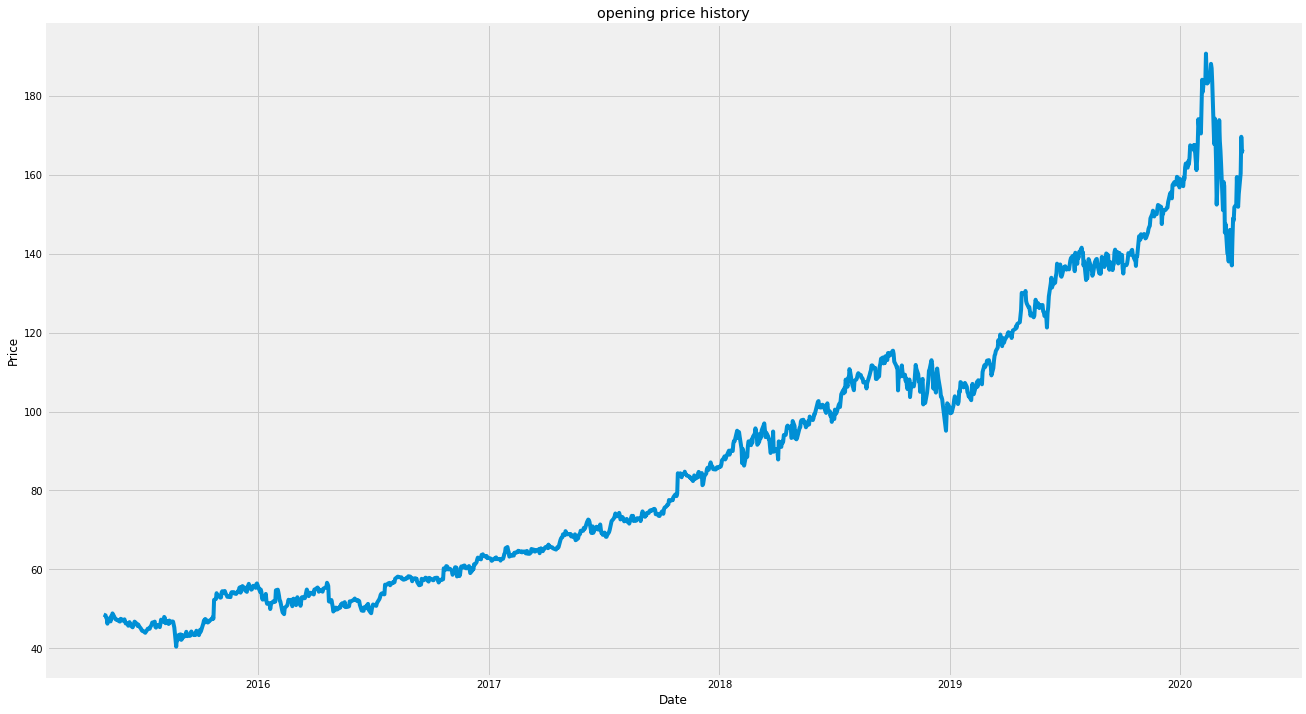

In [7]:
plt.figure(figsize=(20,12))
plt.title("opening price history")
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel("Price")
plt.show()

Create a new datafame with only open column

In [16]:
data = df.filter(items=['Open'])
#convert to numpy
dataset = data.values
#Number of days to train on
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

996

Scaling

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


Create training dataset

In [18]:
train_data = scaled_data[0:train_data_len]

#split data to x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<= 61:
    print("x = {} y = {}".format(x_train,y_train))

x = [array([0.05412784, 0.05272968, 0.0490679 , 0.04740346, 0.03874834,
       0.0472703 , 0.0472703 , 0.04260984, 0.05153128, 0.05046603,
       0.05605858, 0.05013315, 0.04733689, 0.04620505, 0.04547269,
       0.04560585, 0.04247671, 0.04241011, 0.04693741, 0.04647137,
       0.044008  , 0.04314248, 0.04607189, 0.04221039, 0.03901465,
       0.03894806, 0.03535285, 0.0355526 , 0.04134487, 0.03841545,
       0.03328895, 0.03262316, 0.03515312, 0.03841545, 0.04221039,
       0.03914781, 0.03781625, 0.03475365, 0.03715045, 0.03462051,
       0.03055926, 0.02836217, 0.02669773, 0.02683089, 0.02336883,
       0.0258988 , 0.02656457, 0.02862849, 0.03035951, 0.03015978,
       0.03328895, 0.03482024, 0.0370173 , 0.04061251, 0.0412783 ,
       0.0421438 , 0.03322236, 0.03209055, 0.03635153, 0.03655125])] y = [0.03415446939171346]
x = [array([0.05412784, 0.05272968, 0.0490679 , 0.04740346, 0.03874834,
       0.0472703 , 0.0472703 , 0.04260984, 0.05153128, 0.05046603,
       0.05605858, 0.050

Convert x_train and y_train to numpy to use in LSTM

In [0]:
x_train,y_train = np.array(x_train),np.array(y_train)

Reshape the x_train to LSTM.\n
LSTM requires 3 dimentional dataset, #samples,#timesteps,#features

In [20]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(936, 60, 1)

Building the LSTM model

In [0]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compile the model

In [0]:
model.compile(optimizer='adam',loss='mean_squared_error')

Training the model

In [23]:
model.fit(x = x_train, y = y_train, batch_size= 1, epochs= 1)

Epoch 1/1
936/936 [==============================] - 36s 38ms/step - loss: 7.9016e-04


Create the test dataset now

In [24]:
train_data_len

996

In [0]:
test_data = scaled_data[train_data_len - 60: , : ]
x_test = []
y_test = dataset[train_data_len: , : ]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60 : i, 0])

Convert the test data to numpy

In [0]:
x_test = np.array(x_test)

Reshape the data to 3Dimentional

In [0]:
x_test = np.reshape(x_test, newshape= (x_test.shape[0], x_test.shape[1], 1))

Get the model predictions 

In [0]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

Evaluate the prediction (RMSE)



In [29]:
rmse = np.sqrt(np.mean(y_pred - y_test) ** 2 )
rmse

6.133925901359343

Prepare data for plots

In [30]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Visualizations

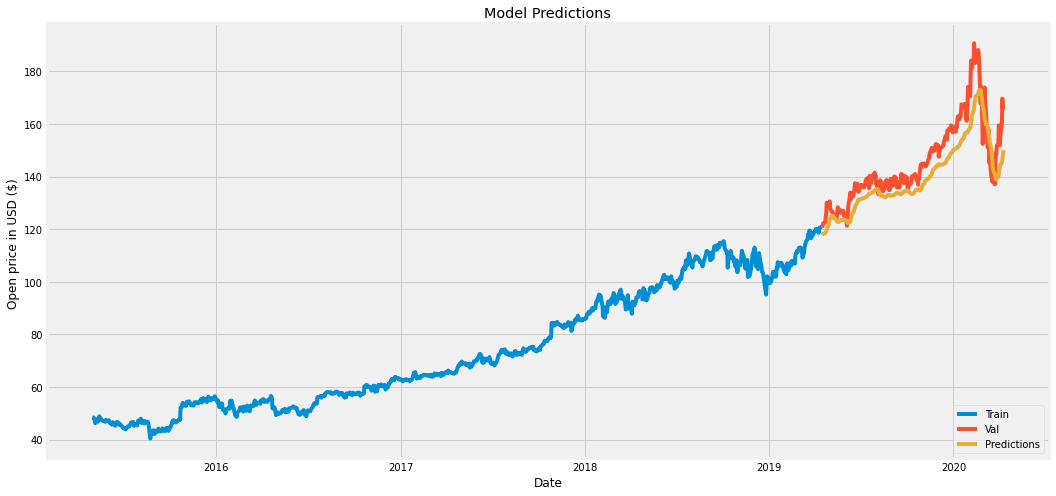

In [31]:
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

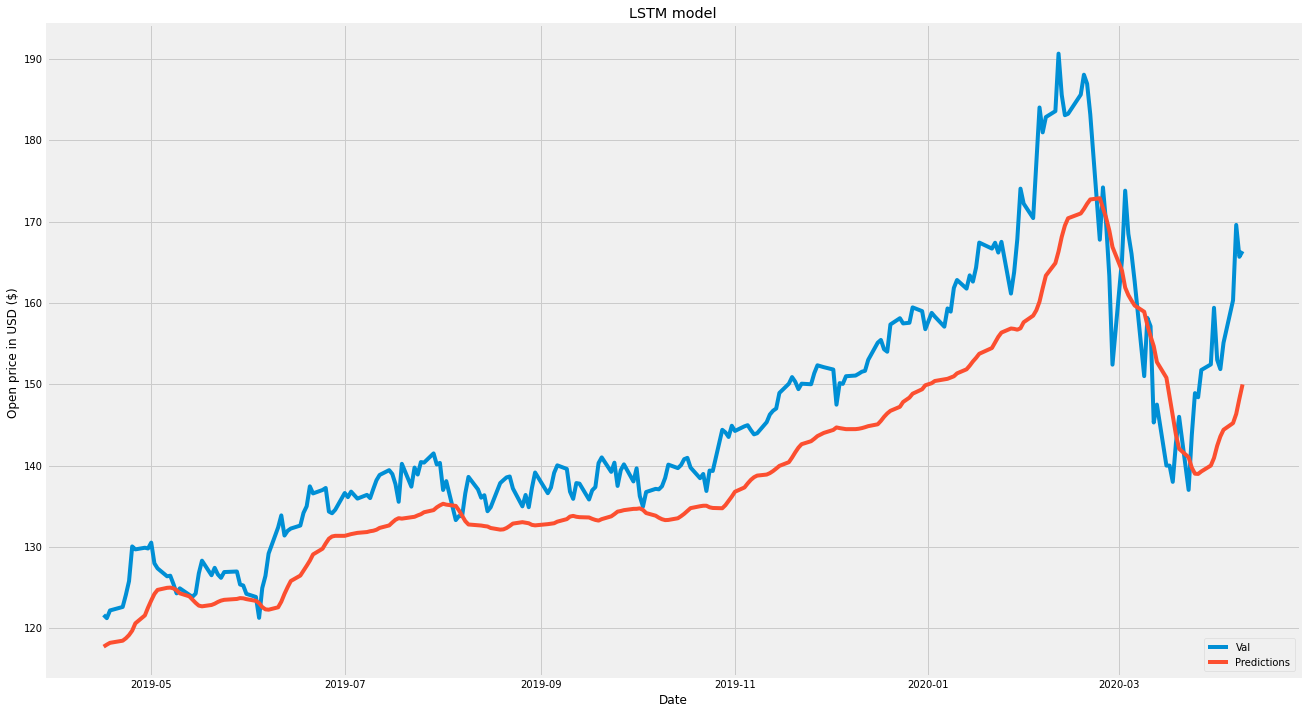

In [94]:
plt.figure(figsize=(20,12))
plt.title("LSTM model")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Val','Predictions'], loc = 'lower right')
plt.show()

Number comparision between actual and predicted

In [33]:
valid

,Open,Predictions
Date,,
2019-04-16,121.639999,117.739624
2019-04-17,121.239998,117.987144
2019-04-18,122.190002,118.208748
2019-04-22,122.620003,118.472000
2019-04-23,124.099998,118.765572
...,...,...
2020-04-03,155.100006,144.402496
2020-04-06,160.320007,145.223129
2020-04-07,169.589996,146.348297


**All Done Here**


Trying out more here onwards. 

In [0]:
msft_quote = web.DataReader('MSFT', data_source= 'yahoo', start='2017-01-03',end='2020-04-13')
new_df = msft_quote.filter(['Open'])

In [35]:
# get last 60 days and convert to numpy
last_60 = new_df[-60: ].values

#scale data
last_60_scaled = scaler.transform(last_60)

#put last 60 to test
x_test = []
x_test.append(last_60_scaled)
x_test = np.array(x_test)

#reshape for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get predicted scaled price
pred_price_scaled = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price_scaled)

print(pred_price)


[[152.894]]


In [36]:
msft_actual = web.DataReader('MSFT', data_source='yahoo', start='2020-01-12', end='2020-04-14')
print("Actual = {} and our Prediction = {}".format(msft_actual["Open"], pred_price))

Actual = Date
2020-01-13    161.759995
2020-01-14    163.389999
2020-01-15    162.619995
2020-01-16    164.350006
2020-01-17    167.419998
                 ...    
2020-04-07    169.589996
2020-04-08    165.669998
2020-04-09    166.360001
2020-04-13    164.350006
2020-04-14    169.000000
Name: Open, Length: 64, dtype: float64 and our Prediction = [[152.894]]


In [37]:
new_df

,Open
Date,
2017-01-03,62.790001
2017-01-04,62.480000
2017-01-05,62.189999
2017-01-06,62.299999
2017-01-09,62.759998
...,...
2020-04-06,160.320007
2020-04-07,169.589996
2020-04-08,165.669998


In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
test_scale = scaler.fit_transform(new_df)

In [0]:
test_x = []
test_y = new_df['Open']

for i in range(60, len(test_scale)):
  test_x.append(test_scale[i-60 : i, 0])

In [0]:
test_x = np.array(test_x)
test_x = np.reshape(test_x, newshape= (test_x.shape[0], test_x.shape[1], 1))

In [0]:
pred_y = model.predict(test_x)
pred_y = scaler.inverse_transform(pred_y)

In [42]:
out_df = new_df[-764:]
out_df['Prediction'] = pred_y
out_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,Prediction
Date,,
2017-03-30,65.419998,68.634903
2017-03-31,65.650002,68.689201
2017-04-03,65.809998,68.770088
2017-04-04,65.389999,68.871506
2017-04-05,66.300003,68.948761
...,...,...
2020-04-06,160.320007,146.906418
2020-04-07,169.589996,148.041473
2020-04-08,165.669998,149.923630


In [0]:
out_df.to_csv('lstm_out_csv.csv')

Combined Models Here


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
import sqlite3

In [0]:
conn = sqlite3.connect('news.db')
read_sql = "SELECT * FROM afinn_news_csv"
senti_df = pd.read_sql(read_sql,conn)
conn.close()

In [0]:
out_df = pd.read_csv('lstm_out_csv.csv')

In [0]:
conn = sqlite3.connect('news.db')
conn.execute("DROP TABLE IF EXISTS lstm_table")
out_df.to_sql('lstm_table',conn)
conn.close()

In [0]:
conn = sqlite3.connect('news.db')
combined_df = pd.read_sql("select published_date,Prediction,sentiment_score,Open from lstm_table inner join afinn_news_csv on published_date = Date",conn)
conn.close()

In [0]:
combined_df.to_csv('combined_data.csv')

In [0]:
combined_df['published_date'] =  pd.to_datetime(combined_df['published_date'])


In [51]:
combined_df

,published_date,Prediction,sentiment_score,Open
0,2017-04-18,69.25163,5.500000,65.330002
1,2017-04-19,69.20744,7.000000,65.650002
2,2017-04-20,69.19211,10.333333,65.459999
3,2017-04-21,69.18212,-0.250000,65.669998
4,2017-04-24,69.19034,2.666667,67.480003
...,...,...,...,...
703,2020-04-03,146.07518,5.621622,155.100006
704,2020-04-06,146.90642,7.348837,160.320007
705,2020-04-07,148.04147,7.488372,169.589996
706,2020-04-08,149.92363,7.702703,165.669998


In [0]:
from sklearn.linear_model import LinearRegression


In [0]:
X = combined_df[['Prediction','sentiment_score']]
Y = combined_df[['Open']]
linear_model = LinearRegression()

In [0]:
train_data_x = X[:500]
train_data_y = Y[:500]
lin_X = StandardScaler()
lin_Y = StandardScaler()
train_X = lin_X.fit_transform(train_data_x)
train_Y = lin_Y.fit_transform(train_data_y)

In [75]:
linear_model.fit(train_X,train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
test_data_x = X[501:]
test_data_y = Y[501:]
lin_test = StandardScaler()
test_X  = lin_test.fit_transform(test_data_x)
pred_data_y = linear_model.predict(test_X)
pred_data_y = lin_Y.inverse_transform(pred_data_y)
pred_data_y = pred_data_y + 35

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [78]:
rms = sqrt(mean_squared_error(test_data_y, pred_data_y))
print(rms)

18.82491996642802


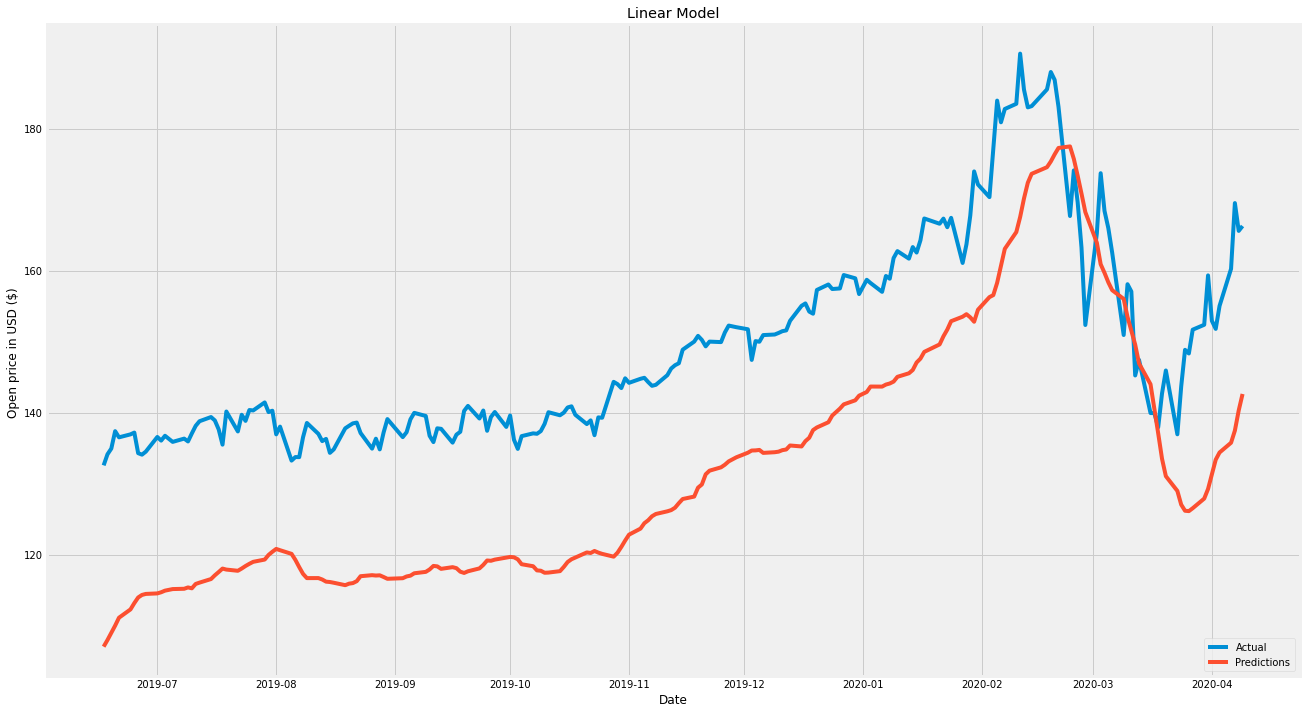

In [95]:
plt.figure(figsize=(20,12))
plt.title("Linear Model")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_data_y)
plt.legend(['Actual','Predictions'], loc = 'lower right')
plt.show()

In [0]:
from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 66) 


In [81]:
regressor.fit(train_X,train_Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=66, verbose=0, warm_start=False)

In [82]:
test_data_x

,Prediction,sentiment_score
501,127.92081,3.868421
502,128.51947,4.382353
503,129.14099,5.709677
504,129.77843,6.305556
505,130.55486,5.583333
...,...,...
703,146.07518,5.621622
704,146.90642,7.348837
705,148.04147,7.488372
706,149.92363,7.702703


In [0]:
pred_rm_y = regressor.predict(test_X)
pred_rm_y = lin_Y.inverse_transform(pred_rm_y)
pred_rm_y = pred_rm_y + 45

In [84]:
rms = sqrt(mean_squared_error(test_data_y, pred_rm_y))
print(rms)

9.396971723062707


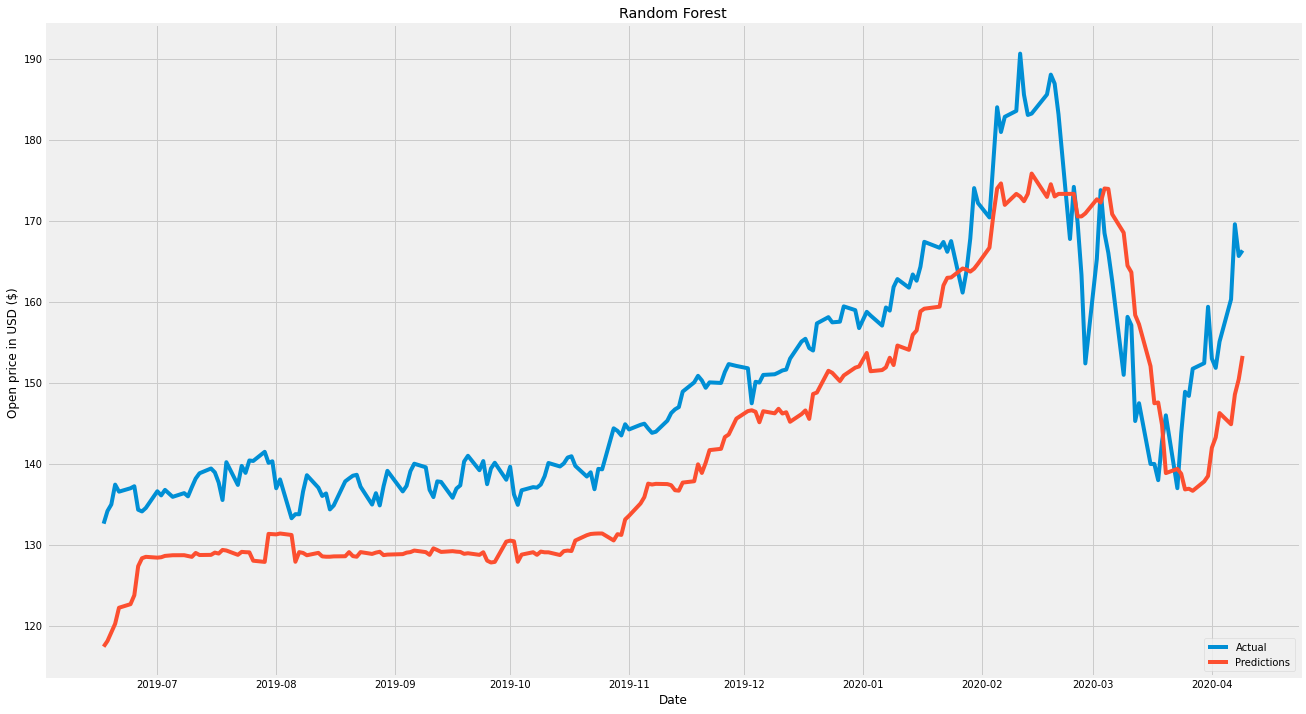

In [85]:
plt.figure(figsize=(20,12))
plt.title("Random Forest")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_rm_y)
plt.legend(['Actual','Predictions'], loc = 'lower right')
plt.show()

In [0]:
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler

In [0]:
svr_reg = SVR()
svm_X = StandardScaler()
svm_Y = StandardScaler()
train_X = svm_X.fit_transform(train_data_x)
train_Y = svm_Y.fit_transform(train_data_y)

In [88]:
svr_reg.fit(train_X,train_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
svm_test = StandardScaler()
test_X  = svm_test.fit_transform(test_data_x)
pred_svr = svr_reg.predict(test_X)
pred_svr = svm_Y.inverse_transform(pred_svr)
pred_svr = pred_svr + 50

In [90]:
rms = sqrt(mean_squared_error(test_data_y, pred_svr))
print(rms)

7.250244863185871


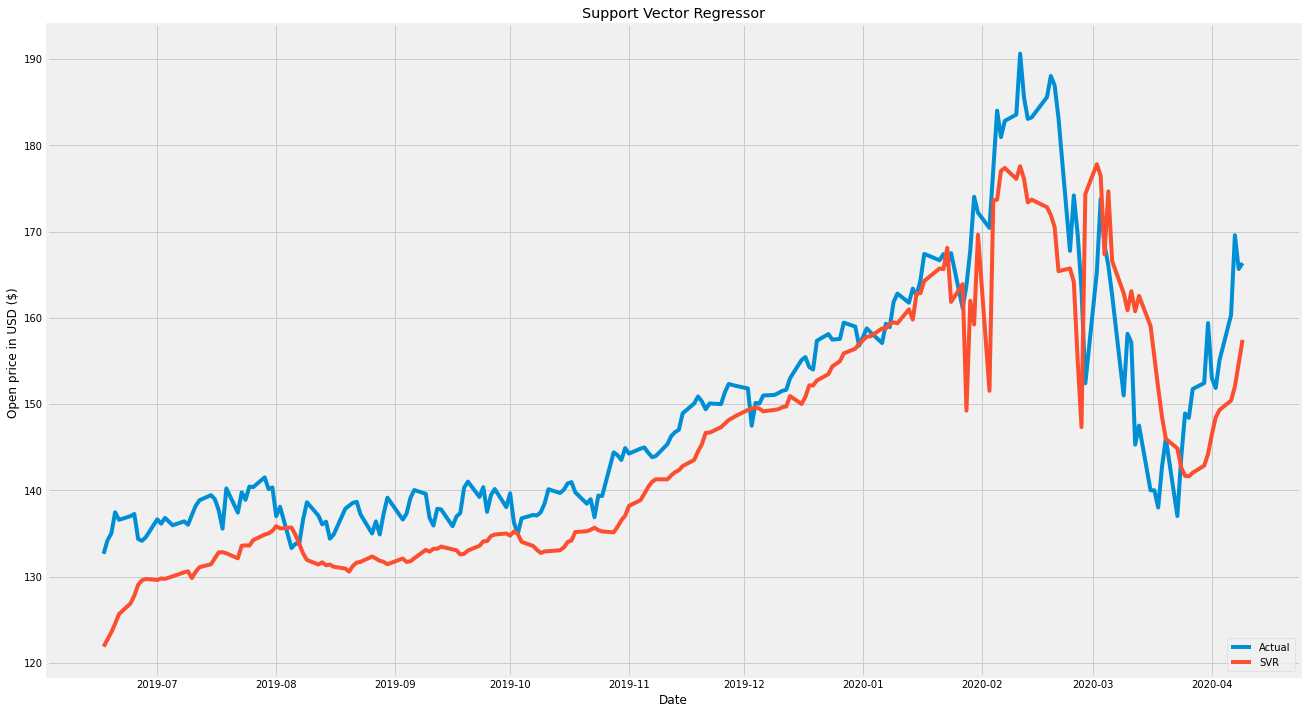

In [91]:
plt.figure(figsize=(20,12))
plt.title("Support Vector Regressor")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_svr)
plt.legend(['Actual','SVR'], loc = 'lower right')
plt.show()

New Method

In [0]:
out_df = pd.read_csv('out_df.tsv',sep='\t')

In [96]:
out_df

,Date,Open,Prediction
0,2017-03-30,65.419998,65.650002
1,2017-03-31,65.650002,65.809998
2,2017-04-03,65.809998,65.389999
3,2017-04-04,65.389999,66.300003
4,2017-04-05,66.300003,65.599998
...,...,...,...
759,2020-04-06,160.320007,169.589996
760,2020-04-07,169.589996,165.669998
761,2020-04-08,165.669998,166.360001
762,2020-04-09,166.360001,164.350006


In [0]:
conn = sqlite3.connect('news.db')
conn.execute("DROP TABLE IF EXISTS lstm_table")
out_df.to_sql('lstm_table',conn)
conn.close()

In [0]:
conn = sqlite3.connect('news.db')
combined_df = pd.read_sql("select published_date,Prediction,sentiment_score,Open from lstm_table inner join afinn_news_csv on published_date = Date",conn)
conn.close()

In [0]:
combined_df.to_csv('combined_data.csv')

In [0]:
combined_df['published_date'] =  pd.to_datetime(combined_df['published_date'])


In [0]:
X = combined_df[['Prediction','sentiment_score']]
Y = combined_df[['Open']]
linear_model = LinearRegression()

In [0]:
train_data_x = X[:500]
train_data_y = Y[:500]
lin_X = StandardScaler()
lin_Y = StandardScaler()
train_X = lin_X.fit_transform(train_data_x)
train_Y = lin_Y.fit_transform(train_data_y)

In [103]:
linear_model.fit(train_X,train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
test_data_x = X[501:]
test_data_y = Y[501:]
lin_test = StandardScaler()
test_X  = lin_test.fit_transform(test_data_x)
pred_data_y = linear_model.predict(test_X)
pred_data_y = lin_Y.inverse_transform(pred_data_y)
pred_data_y = pred_data_y + 40

In [105]:
rms = sqrt(mean_squared_error(test_data_y, pred_data_y))
print(rms)

13.488971049598524


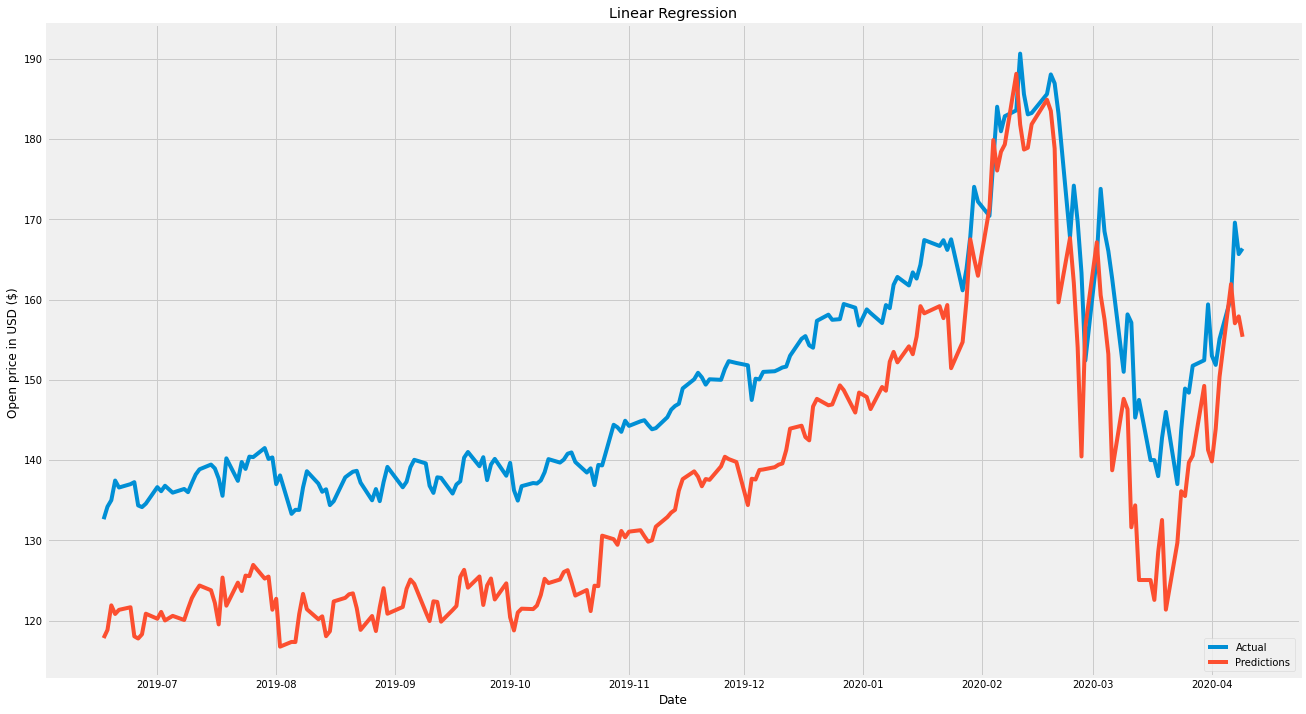

In [106]:
plt.figure(figsize=(20,12))
plt.title("Linear Regression")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_data_y)
plt.legend(['Actual','Predictions'], loc = 'lower right')
plt.show()

In [0]:
from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 66) 


In [108]:
regressor.fit(train_X,train_Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=66, verbose=0, warm_start=False)

In [0]:
pred_rm_y = regressor.predict(test_X)
pred_rm_y = lin_Y.inverse_transform(pred_rm_y)
pred_rm_y = pred_rm_y + 45

In [110]:
rms = sqrt(mean_squared_error(test_data_y, pred_rm_y))
print(rms)

9.158399921230181


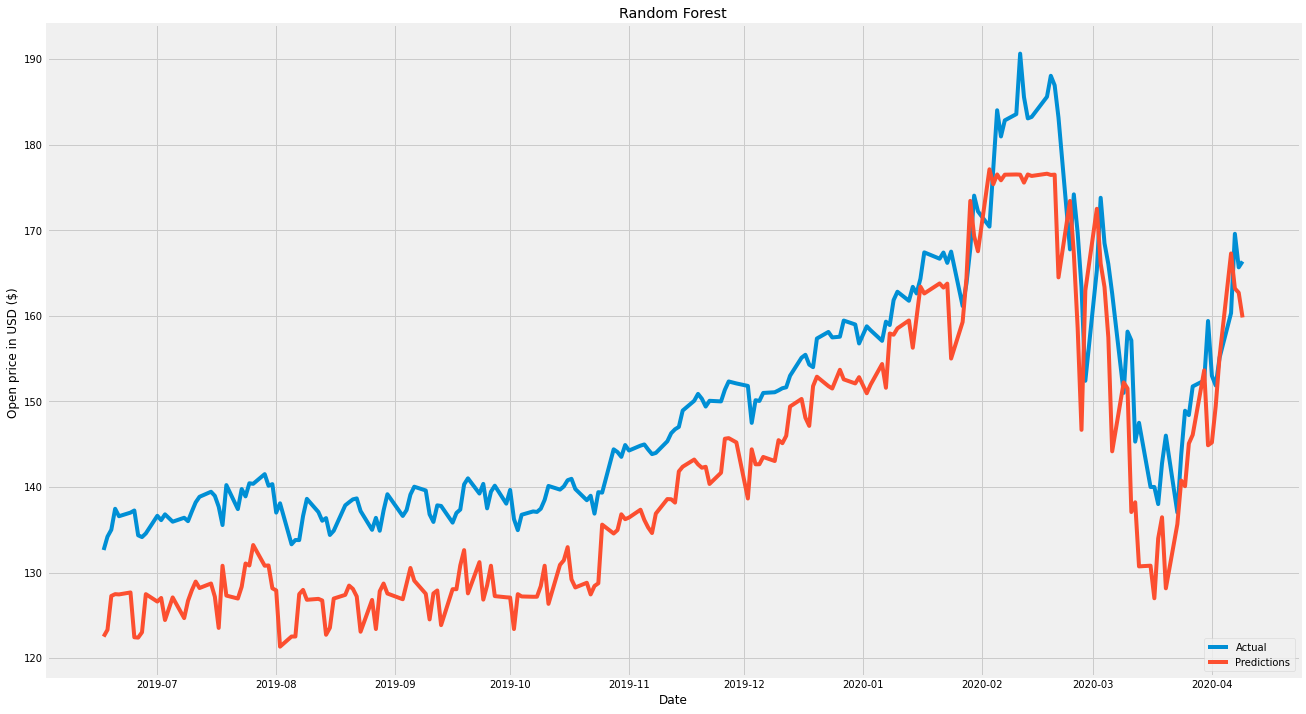

In [111]:
plt.figure(figsize=(20,12))
plt.title("Random Forest")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_rm_y)
plt.legend(['Actual','Predictions'], loc = 'lower right')
plt.show()

In [0]:
svr_reg = SVR()
svm_X = StandardScaler()
svm_Y = StandardScaler()
train_X = svm_X.fit_transform(train_data_x)
train_Y = svm_Y.fit_transform(train_data_y)

In [113]:
svr_reg.fit(train_X,train_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
svm_test = StandardScaler()
test_X  = svm_test.fit_transform(test_data_x)
pred_svr = svr_reg.predict(test_X)
pred_svr = svm_Y.inverse_transform(pred_svr)
pred_svr = pred_svr + 50

In [115]:
rms = sqrt(mean_squared_error(test_data_y, pred_svr))
print(rms)


6.249409633617269


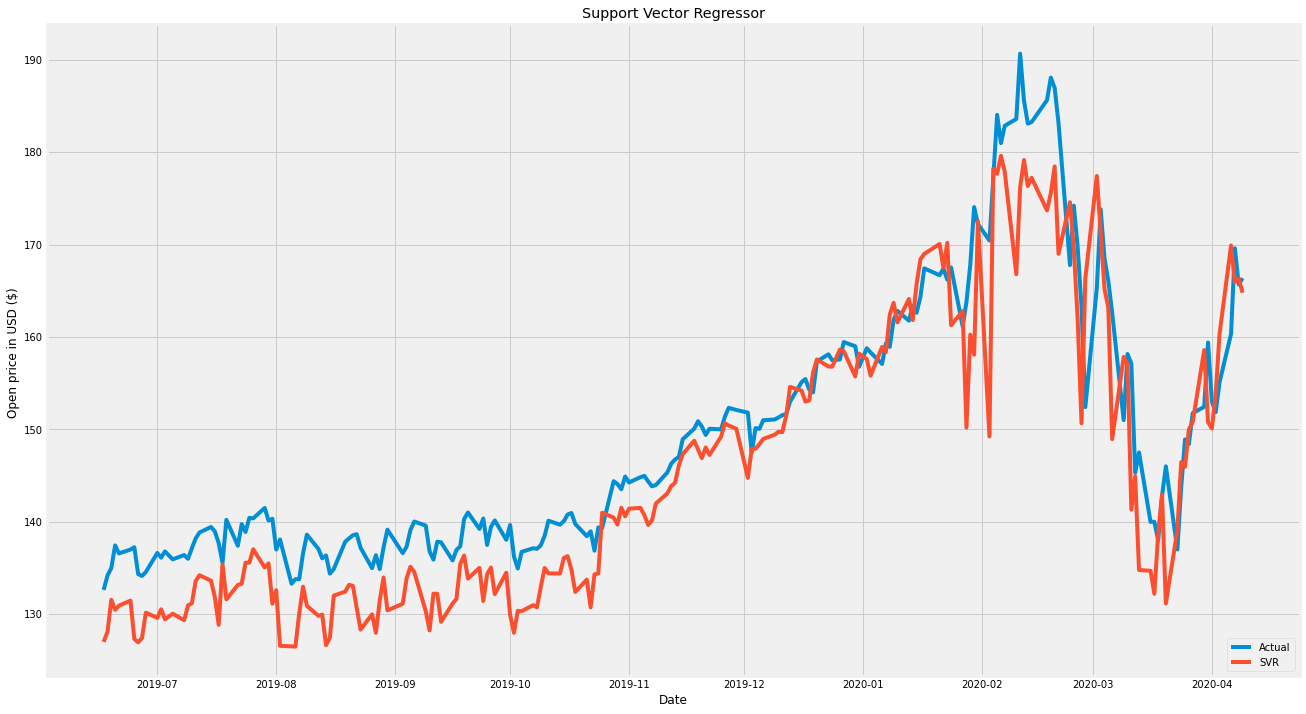

In [116]:
plt.figure(figsize=(20,12))
plt.title("Support Vector Regressor")
plt.xlabel('Date')
plt.ylabel("Open price in USD ($) ")
x_axis = combined_df['published_date']
plt.plot(x_axis[501:],test_data_y)
plt.plot(x_axis[501:],pred_svr)
plt.legend(['Actual','SVR'], loc = 'lower right')
plt.show()